In [58]:
!pip install koeda

     |████████████████████████████████| 566 kB 7.4 MB/s            


In [59]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        # position : padded input size, 행의 크기
        # d_model : 임베딩 차원, 열의 크기
        # angle shape : (1, d_model)
        # position shape : (position, 1)
        # return shape : (position, d_model)
        angles = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            # position * angle을 위해서 newaxis를 작성
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # [2, position, d_model*0.5]
        pos_encoding = tf.stack([sines, cosines], axis=0)
        # [position, d_model*0.5, 2]
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        # [position, d_model], sin과 cosine이 교차
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        # [1, position, d_model]
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        position = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :position, :]
        

In [3]:
def scaled_dot_product_attention(query, key, value, mask):
    # query, key, value : (batch, n_heads, n_token, depth)
    
    # Q·K^T 연산 (키 텐서의 마지막 두 차원 전치)
    # (batch, n_heads, n_token, depth) × (batch, n_heads, depth, n_token)
    # → (batch, n_heads, n_token, n_token)
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # depth : d_model // num_heads (멀티헤드 일 때)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)
        
    # axis = -1 : 각 query에 대해 key들 전체에 softmax를 적용
    # logit의 각 행마다 softmax를 적용함.
    # 모든 행의 합은 각각 1
    # shape : (batch, n_heads, n_token, n_token)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    output = tf.matmul(attention_weights, value)
    # return shape : (batch, n_heads, n_token, depth)
    return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        # shape : (batch, n_token, d_model) 
        # -> (batch, n_token, num_heads, depth)
        # -> (batch, num_heads, n_token, depth)
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # shape : (batch, n_heads, n_token, depth)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # -> (batch, n_token, n_heads, depth)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                     (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [5]:
def create_padding_mask(x):
    # tf.math.equal(x, y) : x와 y의 값이 같으면 True, 아니면 False
    # shape : (batch, 1, 1, seq_length)
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [6]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    """
    tf.linalg.band_part(
    input,      # 입력 텐서 (2D 이상의 행렬)
    num_lower,  # 유지할 하부 대각선(subdiagonal) 수 (음수: 전체 하부 삼각행렬 유지)
    num_upper,  # 유지할 상부 대각선(superdiagonal) 수 (음수: 전체 상부 삼각행렬 유지)
    name=None
    ) : 입력 텐서의 대각선 주변 밴드 영역을 유지하고 나머지를 0으로 설정
    
    num_lower=0, num_upper=-1: 상부 삼각행렬 추출.
    num_lower=-1, num_upper=0: 하부 삼각행렬 추출.
    num_lower=0, num_upper=0: 대각선 요소만 유지.
    """
    # 하부 삼각행렬이 0, 나머지는 1이 되도록
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    # 두 패딩 중 하나라도 1이면 마스크가 적용됨.
    return tf.maximum(look_ahead_mask, padding_mask)
    

In [7]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    # input으로 토큰 1개씩 입력받나?
    # input의 시퀀스의 길이가 가변적임을 의미
    # input shape : (batch, seq_len, d_model)
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # mask는 shape이 (batch, 1, 1, seq_len)이었는데, input이 이게 맞나?
    # 위와 같이 시퀀스의 길이가 가변적이기 때문에 아래와 같이 작성됨.
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    # LayerNormalization에는 왜 inputs + attention을 하지?
    # Residual connection(잔차 연결), 입력과 출력을 더하여 학습을 안정화시켰다.
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    # 여기서는 왜 attention + outputs를 하지?
    # Residual connection, 어텐션블럭의 출력과 feed-foward블럭의 출력을 더했다.
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention+outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_legnth, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    # embedding에 root(d_model)을 곱하는 이유는?
    # transformer 원 논문에서 제안된 트릭, 단어 임베딩과 위치 임베딩의 스케일을 맞추기 위함.
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # positional encoding의 position input에 vocab_size가 들어가는 이유는?
    # positional encoding의 첫 이자는 최대 시퀀스 길이를 의미
    # 실제 입력 시퀀스 길이가 vocab_size보다 짧다면 문제 없다.
    # gpt : vocab_size가 아니라 max_seq_len을 전달하는 편이 좋다.
    embeddings = PositionalEncoding(max_legnth, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                               d_model=d_model,
                               num_heads=num_heads,
                               dropout=dropout,
                               name="encoder_layer_{}".format(i),
                               )([outputs, padding_mask])
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
    

In [9]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    # look_ahead_mask는 디코더의 self-attention에서 사용한다.
    # look_ahed_mask의 shape는 (batch, 1, seq_len_query, seq_len_key)
    # self-attention에서는 seq_q = seq_k 이기 때문에, (batch, 1, seq_len, seq_len) 
    look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1+inputs)
    
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2+attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [10]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_legnth, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 인코더와 같은 vocab size
    embeddings = PositionalEncoding(max_legnth, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units = units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
    

데이터 받아오기

In [11]:
"""path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')"""

'path_to_zip = tf.keras.utils.get_file(\n    \'cornell_movie_dialogs.zip\',\n    origin=\'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip\',\n    extract=True)\n\npath_to_dataset = os.path.join(\n    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")\n\npath_to_movie_lines = os.path.join(path_to_dataset, \'movie_lines.txt\')\npath_to_movie_conversations = os.path.join(path_to_dataset,\'movie_conversations.txt\')'

In [12]:
"""MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
    sentence = sentence.strip().lower()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]', " ", sentence)
    
    sentence = re.sub(r"[^a-zA-Z.?!,]", ' ', sentence)
    sentence = sentence.strip()
    return sentence"""

'MAX_SAMPLES = 50000\n\ndef preprocess_sentence(sentence):\n    sentence = sentence.strip().lower()\n    \n    sentence = re.sub(r"([?.!,])", r" \x01 ", sentence)\n    sentence = re.sub(r\'[" "]\', " ", sentence)\n    \n    sentence = re.sub(r"[^a-zA-Z.?!,]", \' \', sentence)\n    sentence = sentence.strip()\n    return sentence'

In [13]:
"""# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

        for i in range(len(conversation) - 1):
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs"""

"# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수\ndef load_conversations():\n    id2line = {}\n    with open(path_to_movie_lines, errors='ignore') as file:\n        lines = file.readlines()\n    for line in lines:\n        parts = line.replace('\n', '').split(' +++$+++ ')\n        id2line[parts[0]] = parts[4]\n\n    inputs, outputs = [], []\n    with open(path_to_movie_conversations, 'r') as file:\n        lines = file.readlines()\n\n    for line in lines:\n        parts = line.replace('\n', '').split(' +++$+++ ')\n        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]\n\n        for i in range(len(conversation) - 1):\n            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.\n            inputs.append(preprocess_sentence(id2line[conversation[i]]))\n            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))\n\n            if len(inputs) >= MAX_SAMPLES:\n                return inputs, outputs\n    return inputs, outputs"

In [14]:
"""questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))"""

"questions, answers = load_conversations()\nprint('전체 샘플 수 :', len(questions))\nprint('전체 샘플 수 :', len(answers))"

In [161]:
path_to_dataset = "./data/ChatbotData.csv"
dataframe = pd.read_csv(path_to_dataset)
dataframe.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [162]:
def preprocess_sentence(sentence):
    # 특수문자 제거
    sentence = re.sub(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]', ' ', sentence)
    # 중복 문자 정규화
    sentence = re.sub(r'(.)\1{2,}', r'\1\1', sentence)
    # ?.!, 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [163]:
questions = dataframe['Q'].apply(preprocess_sentence)
answers = dataframe['A'].apply(preprocess_sentence)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [164]:
print(questions[:5])
print(answers[:5])

0              12시 땡
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object
0     하루가 또 가네요
1      위로해 드립니다
2    여행은 언제나 좋죠
3    여행은 언제나 좋죠
4     눈살이 찌푸려지죠
Name: A, dtype: object


In [165]:
import koeda
augmenter = koeda.EDA(morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.1, alpha_rs=0.1, prob_rd=0.1)
aug_questions, aug_answers = [], []
for q, a in zip(questions, answers):
    aug_q = augmenter(q, repetition=3)
    for aug in aug_q:
        aug_questions.append(str(aug))
        aug_answers.append(a)

In [166]:
aug_df= pd.DataFrame({'question': aug_questions,
                                'answer':aug_answers})

print(f"원본 데이터 수: {len(questions)}")
print(f"증강 데이터 수: {len(aug_questions)}")
#print(f"최종 학습 데이터 수: {len(all_questions)}")

원본 데이터 수: 11823
증강 데이터 수: 35469


In [167]:
aug_df = aug_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [168]:
display(aug_df.head(10))
questions = aug_df['question']
answers = aug_df['answer']

print(f"최종 학습 데이터 수: {len(questions)}")
print(questions[0], answers[0])

,question,answer
0,말문이 탁 막힌다,생각지도 못한 일이 일어났나봐요
1,썸 기 타는 기간,정해져 있지는 않지만 발전된 관계가 좋겠죠
2,어제 또 톡보내버렸네,달라지지 않는다면 연락은 하지마세요
3,이승로 짝남 보내기로 했어요,힘든 결정이었을텐데 맘고생 많았어요
4,휴학할까,계획 세우고 하세요
5,양배추즙맛없어,먹으면서 다이어트 하는 분들 진짜 엄청 대단한 분들이에요
6,여자친구가 스킨십 등기 싫대,좀 더 기다려주세요
7,꿈에 나온 여자를 촉망 어떻게 찾을 수 있을까,서울에서 왕서방 찾기네요
8,매일 그녀 꿈을 꾸네,그녀 생각이 많이 나서 그럴거예요
9,처음엔 좋았는데,그 사람의 좋은점을 생각해보세요


최종 학습 데이터 수: 35469
말문이 탁 막힌다 생각지도 못한 일이 일어났나봐요


In [169]:
print(aug_df.isnull().sum())
aug_df = aug_df.dropna()

question    0
answer      0
dtype: int64


In [170]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

VOCAB_SIZE = tokenizer.vocab_size + 2

MAX_LENGTH = 40

In [171]:
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 문장 [650, 1934, 10, 1072, 8437, 8362, 8346, 94]
기존 문장: 결혼해서도 설렐까
650 ----> 결혼
1934 ----> 해서
10 ----> 도 
1072 ----> 설
8437 ----> �
8362 ----> �
8346 ----> �
94 ----> 까


In [172]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [173]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8460
필터링 후의 질문 샘플 개수: 35469
필터링 후의 답변 샘플 개수: 35469


In [174]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] 
    },
    {
        'outputs': answers[:, 1:]
    }))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    트랜스포머 모델 정의

In [175]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, max_length, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더 패딩
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape = (1, 1, None),
        name='enc_padding_mask')(inputs)
    # 디코더 패딩, 셀프어텐션부분
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # 디코더 패딩, 크로스어텐션부분
    # dec_padding_mask의 input이 인코더패딩의 input과 같은 이유?
    # 디코더의 크로스 어텐션 레이어가 인코더 출력의 패딩 토큰을 무시하기 위해 필요하기 때문
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        max_legnth=max_length)(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        max_legnth=max_length)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
    

    모델 생성

In [176]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
MAX_LENGTH = 40

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_length = MAX_LENGTH)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3219968     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

    손실 함수

In [177]:
def loss_function(y_true, y_pred):
    # y_true를 (배치*시퀀스 길이) 형태로 재구성
    # MAX_LENGTH - 1 의 이유 : 디코더 출력에서 <START> 토큰을 제외한 길이만큼 예측
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    
    # from_logits=True : y_pred가 softmax를 거치지 않았음을 명시
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    # 패딩 토큰 위치를 마스킹하는 mask
    mask  = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    # 각 위치별 손실에 마스크를 곱해 패딩위치의 손실을 0으로
    loss = tf.multiply(loss, mask)
    # 전체 손실의 평균값 반환
    return tf.reduce_mean(loss)

In [178]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

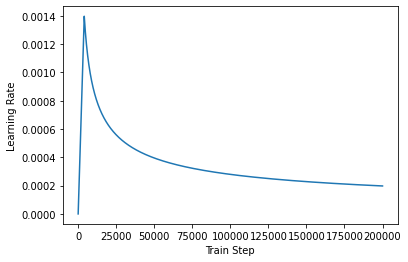

In [179]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [180]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [181]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
555/555 [==============================] - 37s 56ms/step - loss: 1.1248 - accuracy: 0.0238
Epoch 2/50
555/555 [==============================] - 31s 56ms/step - loss: 0.8688 - accuracy: 0.0334
Epoch 3/50
555/555 [==============================] - 31s 56ms/step - loss: 0.6768 - accuracy: 0.0512
Epoch 4/50
555/555 [==============================] - 32s 57ms/step - loss: 0.4650 - accuracy: 0.0751
Epoch 5/50
555/555 [==============================] - 32s 57ms/step - loss: 0.2702 - accuracy: 0.1009
Epoch 6/50
555/555 [==============================] - 32s 58ms/step - loss: 0.1436 - accuracy: 0.1209
Epoch 7/50
555/555 [==============================] - 32s 58ms/step - loss: 0.0875 - accuracy: 0.1307
Epoch 8/50
555/555 [==============================] - 32s 58ms/step - loss: 0.0648 - accuracy: 0.1349
Epoch 9/50
555/555 [==============================] - 32s 58ms/step - loss: 0.0443 - accuracy: 0.1396
Epoch 10/50
555/555 [==============================] - 33s 59ms/step - loss: 0.032

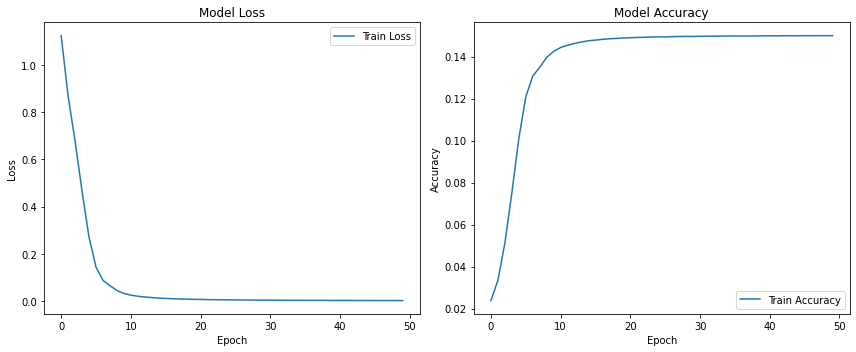

In [182]:
# 학습 과정 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [189]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
          START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

      # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [190]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [209]:
sentence_generation("영화볼래?")

입력 : 영화볼래?
출력 : 최신 영화가 좋을 것 같아요


'최신 영화가 좋을 것 같아요'

In [208]:
sentence_generation("자연어처리 공부를 해야지")

입력 : 자연어처리 공부를 해야지
출력 : 하나씩 해보세요


'하나씩 해보세요'

In [193]:
sentence_generation("점심 뭐 먹을까?")

입력 : 점심 뭐 먹을까?
출력 : 맛있는 거 드세요


'맛있는 거 드세요'

In [194]:
sentence_generation("심심해")

입력 : 심심해
출력 : 친구들과 연락해보세요


'친구들과 연락해보세요'

In [212]:
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_length = MAX_LENGTH)

model.summary()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3219968     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [213]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
555/555 [==============================] - 39s 55ms/step - loss: 1.1356 - accuracy: 0.0235
Epoch 2/30
555/555 [==============================] - 31s 56ms/step - loss: 0.9176 - accuracy: 0.0300
Epoch 3/30
555/555 [==============================] - 31s 56ms/step - loss: 0.7849 - accuracy: 0.0389
Epoch 4/30
555/555 [==============================] - 31s 57ms/step - loss: 0.6262 - accuracy: 0.0539
Epoch 5/30
555/555 [==============================] - 32s 57ms/step - loss: 0.4715 - accuracy: 0.0709
Epoch 6/30
555/555 [==============================] - 32s 57ms/step - loss: 0.3497 - accuracy: 0.0865
Epoch 7/30
555/555 [==============================] - 32s 58ms/step - loss: 0.2638 - accuracy: 0.0986
Epoch 8/30
555/555 [==============================] - 32s 58ms/step - loss: 0.2076 - accuracy: 0.1074
Epoch 9/30
555/555 [==============================] - 32s 58ms/step - loss: 0.1616 - accuracy: 0.1151
Epoch 10/30
555/555 [==============================] - 32s 58ms/step - loss: 0.130

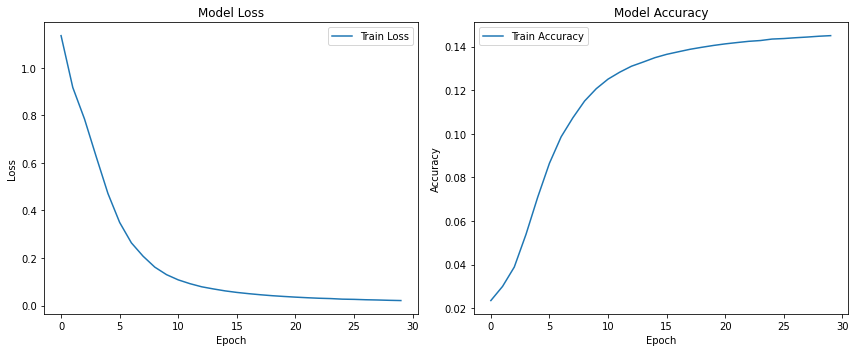

In [214]:
# 학습 과정 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [215]:
sentence_generation("영화볼래?")

입력 : 영화볼래?
출력 : 저도 영화 보여주세요


'저도 영화 보여주세요'

In [218]:
sentence_generation("영화 추천 해줘")

입력 : 영화 추천 해줘
출력 : 최신 영화가 좋을 것 같아요


'최신 영화가 좋을 것 같아요'

In [222]:
sentence_generation("자연어처리 공부를 하자")

입력 : 자연어처리 공부를 하자
출력 : 하나씩 해보세요


'하나씩 해보세요'

In [217]:
sentence_generation("점심 뭐 먹을까?")

입력 : 점심 뭐 먹을까?
출력 : 맛있는 거 드세요


'맛있는 거 드세요'

In [221]:
sentence_generation("심심해")

입력 : 심심해
출력 : 노래 불러 드릴까요  북치기박치기 헥헥


'노래 불러 드릴까요  북치기박치기 헥헥'

### 회고
'''
트랜스포머 코드를 공부할 수 있는 좋은 기회로, 많은 공부가 되었습니다.
학습 그래프를 보면 학습률이 작은 상태로 지속되어 과대적합인가 생각이 들었는데,
validation set을 만들어서 훈련하면 과대적합을 판별할 수 있는지,
아니면 생성모델이기 때문에 validation set보다도 정성적인 평가가 더 중요한지 궁금했습니다.
'''